# Importing the required python libraries



In [1]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt 
import seaborn as sb # used to plot the heatmap

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(0)
start = time.time()

# Creating a python class for loading the data into Neural network

In [2]:
class TabularDataset(Dataset):
    def __init__(self, data, cat_cols=None, output_col=None):
        """
        Characterizes a Dataset for PyTorch

        Parameters
        ----------

        data: pandas data frame
        The data frame object for the input data. It must
        contain all the continuous, categorical and the
        output columns to be used.

        cat_cols: List of strings
        The names of the categorical columns in the data.
        These columns will be passed through the embedding
        layers in the model. These columns must be
        label encoded beforehand. 

        output_col: string
        The name of the output variable column in the data
        provided.
        """

        self.n = data.shape[0] # n stores the total number of data points

        if output_col:
            self.y = data[output_col].astype(np.float32).values.reshape(-1, 1) #data[output_col] contains two columns 
                                                                            #(first column is the index). This line converts it 
                                                                            # to single column
            
        else:
            self.y = np.zeros((self.n, 1)) # a general case when out

        self.cat_cols = cat_cols if cat_cols else [] # categorical inputs are stored in "self.cat_cols"
        self.cont_cols = [
            col for col in data.columns if col not in self.cat_cols + [output_col] # finds out the columns that have 
                                                                                   # contionuos inputs
        ]

        if self.cont_cols:
            self.cont_X = data[self.cont_cols].astype(np.float32).values # The data corresponding to 
                                                                         # continuous columns are stored in "self.cont_x"
        else:
            self.cont_X = np.zeros((self.n, 1))

        if self.cat_cols:
            self.cat_X = data[cat_cols].astype(np.int64).values # The data corresponding to 
                                                                # categorical columns are stored in "self.cont_x"
        else:
            self.cat_X = np.zeros((self.n, 1))

    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return self.n

    def __getitem__(self, idx):
        """
        Generates one sample of data as a triplet --> #(output, continous inputs, categorical inputs)
        """
        return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

# Definition of the Neural network

In [3]:
class FeedForwardNN(nn.Module):
    def __init__(
        self,
        emb_dims,
        no_of_cont,
        lin_layer_sizes,
        output_size,
        emb_dropout,
        lin_layer_dropouts,
    ):

        """
        Parameters
        ----------

        emb_dims: List of two element tuples
        This list will contain a two element tuple for each
        categorical feature. The first element of a tuple will
        denote the number of unique values of the categorical
        feature. The second element will denote the embedding
        dimension to be used for that feature.

        no_of_cont: Integer
        The number of continuous features in the data.

        lin_layer_sizes: List of integers.
        The size of each linear layer. The length will be equal
        to the total number
        of linear layers in the network.

        output_size: Integer
        The size of the final output.

        emb_dropout: Float
        The dropout to be used after the embedding layers.

        lin_layer_dropouts: List of floats
        The dropouts to be used after each linear layer.
        """

        super().__init__()

        # Embedding layers of categorical inputs
        self.emb_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])

        no_of_embs = sum([y for x, y in emb_dims])
        self.no_of_embs = no_of_embs
        self.no_of_cont = no_of_cont

        # Linear Layers of the nueral network
        first_lin_layer = nn.Linear(
            self.no_of_embs + self.no_of_cont, lin_layer_sizes[0]
        ) # first layer where data is fed into the network
        # Following lines define the hidden layers
        self.lin_layers = nn.ModuleList(
            [first_lin_layer]
            + [
                nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
                for i in range(len(lin_layer_sizes) - 1)
            ]
        )
        # Initializing the weights of neural network layers
        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data)

        # Output Layer
        self.output_layer = nn.Linear(lin_layer_sizes[-1], output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data)

        # Batch Norm Layers, It is used to normalize the data into the layers to avoid overfitting and to optimize network
        self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
        self.bn_layers = nn.ModuleList(
            [nn.BatchNorm1d(size) for size in lin_layer_sizes]
        )

        # Dropout Layers used as regularization
        self.emb_dropout_layer = nn.Dropout(emb_dropout)
        self.droput_layers = nn.ModuleList(
            [nn.Dropout(size) for size in lin_layer_dropouts]
        )

    def forward(self, cont_data, cat_data):
        # This function defines the mathematical operations of the neural network 
        if self.no_of_embs != 0: # Defines the embedding layer of categorical inputs
            x = [
                emb_layer(cat_data[:, i]) for i, emb_layer in enumerate(self.emb_layers)
            ]
            x = torch.cat(x, 1)
            x = self.emb_dropout_layer(x) # dropout regularization of categorical inputs 

        if self.no_of_cont != 0:
            normalized_cont_data = self.first_bn_layer(cont_data) # defines the linear (normal nueral net hidden layer)
                                                                  # for continous inputs

            if self.no_of_embs != 0:
                x = torch.cat([x, normalized_cont_data], 1)
            else:
                x = normalized_cont_data
        # Batch normalization operation is done in this for loop
        for lin_layer, dropout_layer, bn_layer in zip( 
            self.lin_layers, self.droput_layers, self.bn_layers
        ):

            x = F.relu(lin_layer(x))
#             x = F.sigmoid(lin_layer(x))
            x = bn_layer(x)
            x = dropout_layer(x)

        x = self.output_layer(x)

        return x # Returns the output of the network

# Data loading and preprocessing

In [6]:
# The data is read as a pandas data frame
data_consolidated = pd.read_excel("newdatafile.xlsx", sheet_name=None)

In [17]:
data_consolidated['0']

,Unnamed: 0,in:Date/Time,in:Hour,in:Orientation,in:Building 00,in:Building 01,in:Building 02,in:Building 03,in:Facade level Height,in:Glazing Type - U-value W/m2K,...,in:Operative Temperature,out:Cooling Loads - KW/m2,out:Heating Loads - KW/m2,out:Lighting Loads - KW/m2,out:Equipments Loads - KW/m2,out:Total Cooling Loads - KW/m2,out:Total Heating Loads - KW/m2,out:Total Lighting Loads - KW/m2,out:Total Equipments Loads - KW/m2,out:Total EUI - KW/m2
0,0,01/01 01:00:00,1,0,Low,Low,Medium,High,12,SingleG0,...,15.962109,0.0,0.000000,0.00015,0.0008,93.070947,17.598212,9.7059,9.4888,129.863858
1,1,01/01 02:00:00,2,0,Low,Low,Medium,High,12,SingleG0,...,15.651486,0.0,0.000000,0.00015,0.0008,NaN,NaN,NaN,NaN,NaN
2,2,01/01 03:00:00,3,0,Low,Low,Medium,High,12,SingleG0,...,15.405255,0.0,0.000000,0.00015,0.0008,NaN,NaN,NaN,NaN,NaN
3,3,01/01 04:00:00,4,0,Low,Low,Medium,High,12,SingleG0,...,15.205198,0.0,0.000000,0.00015,0.0008,NaN,NaN,NaN,NaN,NaN
4,4,01/01 05:00:00,5,0,Low,Low,Medium,High,12,SingleG0,...,15.036366,0.0,0.000000,0.00015,0.0008,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8755,12/31 20:00:00,8756,0,Low,Low,Medium,High,12,SingleG0,...,19.667946,0.0,0.014062,0.00015,0.0006,NaN,NaN,NaN,NaN,NaN
8756,8756,12/31 21:00:00,8757,0,Low,Low,Medium,High,12,SingleG0,...,19.431945,0.0,0.015745,0.00015,0.0006,NaN,NaN,NaN,NaN,NaN
8757,8757,12/31 22:00:00,8758,0,Low,Low,Medium,High,12,SingleG0,...,19.198375,0.0,0.017981,0.00015,0.0006,NaN,NaN,NaN,NaN,NaN
8758,8758,12/31 23:00:00,8759,0,Low,Low,Medium,High,12,SingleG0,...,18.998844,0.0,0.020028,0.00015,0.0006,NaN,NaN,NaN,NaN,NaN


In [18]:
frames =[keys for keys in data_consolidated]
data = pd.concat([data_consolidated['0'], data_consolidated['1']])


In [21]:
data = data_consolidated['0']
for i in range(1,len(data_consolidated)):
    data = pd.concat([data, data_consolidated[str(i)]])

In [40]:
data.columns

Index(['Unnamed: 0', 'in:Date/Time', 'in:Hour', 'in:Orientation',
       'in:Building 00', 'in:Building 01', 'in:Building 02', 'in:Building 03',
       'in:Facade level Height', 'in:Glazing Type - U-value W/m2K',
       'in:Exterior Wall - U-value W/m2K', 'in:AF Shading State',
       'in:AF-(Opening Percentage)', 'in:AF-Shade Factor',
       'in:Solar Radiation W/m2', 'in:Operative Temperature',
       'out:Cooling Loads - KW/m2', 'out:Heating Loads - KW/m2',
       'out:Lighting Loads - KW/m2', 'out:Equipments Loads - KW/m2 ',
       'out:Total Cooling Loads - KW/m2', 'out:Total Heating Loads - KW/m2',
       'out:Total Lighting Loads - KW/m2',
       'out:Total Equipments Loads - KW/m2', 'out:Total EUI - KW/m2'],
      dtype='object')

In [43]:
data=data.drop(['Unnamed: 0', 'in:Date/Time', 'in:Hour', 'in:Building 02', 'in:Building 03','in:AF Shading State', 
                'out:Heating Loads - KW/m2', 'out:Lighting Loads - KW/m2', 'out:Equipments Loads - KW/m2 ',
                'out:Total Cooling Loads - KW/m2', 'out:Total Heating Loads - KW/m2',
                'out:Total Lighting Loads - KW/m2',
                'out:Total Equipments Loads - KW/m2', 'out:Total EUI - KW/m2'
               ], axis=1)

In [46]:
data_org=data

In [54]:
data.shape

(11344200, 11)

In [63]:
data_4 = np.zeros((0,11))
for i in range(1295):
    tmp1 = data.iloc[((i*8760)+1416):((i*8760)+2160),:]
    tmp2 = data.iloc[((i*8760)+3624):((i*8760)+4344),:]
    tmp3 = data.iloc[((i*8760)+5832):((i*8760)+6552),:]
    tmp4 = data.iloc[((i*8760)+8016):((i*8760)+8760),:]
    
    data_4 = np.concatenate((data_4,tmp1,tmp2,tmp3,tmp4), axis=0)

In [65]:
data = data_4

In [69]:
data = pd.DataFrame(data, columns = data_org.columns)

In [71]:
data

,in:Orientation,in:Building 00,in:Building 01,in:Facade level Height,in:Glazing Type - U-value W/m2K,in:Exterior Wall - U-value W/m2K,in:AF-(Opening Percentage),in:AF-Shade Factor,in:Solar Radiation W/m2,in:Operative Temperature,out:Cooling Loads - KW/m2
0,0,Low,Low,12,SingleG0,0,0.0,1.0,0.0,17.428003,0.0
1,0,Low,Low,12,SingleG0,0,0.0,1.0,0.0,17.150332,0.0
2,0,Low,Low,12,SingleG0,0,0.0,1.0,0.0,16.914902,0.0
3,0,Low,Low,12,SingleG0,0,0.0,1.0,0.0,16.69424,0.0
4,0,Low,Low,12,SingleG0,0,0.0,1.0,0.0,16.474319,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3791755,3,High,High,60,TripleGlz-Krypton Filled,2,0.0,1.0,0.0,19.278899,0.0
3791756,3,High,High,60,TripleGlz-Krypton Filled,2,0.0,1.0,0.0,19.17135,0.0
3791757,3,High,High,60,TripleGlz-Krypton Filled,2,0.0,1.0,0.0,19.070901,0.0
3791758,3,High,High,60,TripleGlz-Krypton Filled,2,0.0,1.0,0.0,18.967557,0.0


In [72]:
hours=np.array([range(1,25)])

hours=hours.T
hours.shape
H=np.tile(hours,[157990,1])
data['in:Hour'] = H
print(data.columns)

Index(['in:Orientation', 'in:Building 00', 'in:Building 01',
       'in:Facade level Height', 'in:Glazing Type - U-value W/m2K',
       'in:Exterior Wall - U-value W/m2K', 'in:AF-(Opening Percentage)',
       'in:AF-Shade Factor', 'in:Solar Radiation W/m2',
       'in:Operative Temperature', 'out:Cooling Loads - KW/m2', 'in:Hour'],
      dtype='object')


In [73]:
months1 = np.array([3])
months1 = np.tile(months1, [744,1])
months2 = np.array([6])
months2 = np.tile(months2, [720,1])
months3 = np.array([9])
months3 = np.tile(months3, [720,1])
months4 = np.array([12])
months4 = np.tile(months4, [744,1])
months = np.concatenate((months1, months2,months3, months4), axis=0)
months = np.tile(months, [1295,1])
months.shape
data['in:Month'] = months

In [74]:
daytype1 = np.zeros((1,1))
for i in range(30):
    t = np.repeat(i+1,24)
    t = np.reshape(t,(t.shape[0],1))
#     print(t)
#     print(t.shape)
    daytype1 = np.concatenate((daytype1, t  ), axis=0)

daytype1 = daytype1[1:,:]
t = np.repeat(31,24)
t = np.reshape(t,(t.shape[0],1))
daytype2 = np.concatenate((daytype1, t), axis=0) 

day = np.concatenate((daytype1, daytype2, daytype2, daytype1), axis=0)
day = np.tile(day, [1295,1])
data['in:day'] = day
data

,in:Orientation,in:Building 00,in:Building 01,in:Facade level Height,in:Glazing Type - U-value W/m2K,in:Exterior Wall - U-value W/m2K,in:AF-(Opening Percentage),in:AF-Shade Factor,in:Solar Radiation W/m2,in:Operative Temperature,out:Cooling Loads - KW/m2,in:Hour,in:Month,in:day
0,0,Low,Low,12,SingleG0,0,0.0,1.0,0.0,17.428003,0.0,1,3,1.0
1,0,Low,Low,12,SingleG0,0,0.0,1.0,0.0,17.150332,0.0,2,3,1.0
2,0,Low,Low,12,SingleG0,0,0.0,1.0,0.0,16.914902,0.0,3,3,1.0
3,0,Low,Low,12,SingleG0,0,0.0,1.0,0.0,16.69424,0.0,4,3,1.0
4,0,Low,Low,12,SingleG0,0,0.0,1.0,0.0,16.474319,0.0,5,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791755,3,High,High,60,TripleGlz-Krypton Filled,2,0.0,1.0,0.0,19.278899,0.0,20,12,30.0
3791756,3,High,High,60,TripleGlz-Krypton Filled,2,0.0,1.0,0.0,19.17135,0.0,21,12,30.0
3791757,3,High,High,60,TripleGlz-Krypton Filled,2,0.0,1.0,0.0,19.070901,0.0,22,12,30.0
3791758,3,High,High,60,TripleGlz-Krypton Filled,2,0.0,1.0,0.0,18.967557,0.0,23,12,30.0


### One-hot encoding of categorical features

In [75]:
from scipy import sparse
# Array that specifies which columns are categorical inputs
categorical_features = [ 'in:Orientation', 'in:Building 00',
       'in:Building 01', 'in:Glazing Type - U-value W/m2K',
       'in:Exterior Wall - U-value W/m2K', 'in:Hour', 'in:Month', 'in:day',] # Except column "7", all are label encoded and "7" is 
                                                               # one-hot encoded. 
# Array that specifies which columns are continuous inputs
contnuous_features = ['in:Facade level Height','in:AF-(Opening Percentage)', 'in:AF-Shade Factor',
       'in:Solar Radiation W/m2', 'in:Operative Temperature']
output_feature = 'out:Cooling Loads - KW/m2'  # specifies which column is output


temp={}
label_encoders = {} 
# for loop starts for label encoding
for i in range(0,len(categorical_features)):
    #codes for one-hot encoding
    label_encoders[categorical_features[i]] = OneHotEncoder(sparse = 'True',handle_unknown='ignore')
    label_encoders[categorical_features[i]].fit(data[categorical_features[i]].values.reshape(-1,1))
    temp[categorical_features[i]]=label_encoders[categorical_features[i]].transform(data[categorical_features[i]].values.reshape(-1,1)).toarray() 

In [76]:
#printing the dimensions of each categorical variables after one-hot encoding
for i in range(0,len(temp)):
    print(temp[categorical_features[i]].shape)

(3791760, 4)
(3791760, 3)
(3791760, 3)
(3791760, 4)
(3791760, 3)
(3791760, 24)
(3791760, 4)
(3791760, 31)


In [77]:
# Adding the one hot encoded features into the data
# The new columns will be named from 13 onwards.
ind=1
new_categorical_features=[]
for i in range(0,len(categorical_features)):
    for j in range(0,temp[categorical_features[i]].shape[1]):
        data[str(ind)] = temp[categorical_features[i]][:,j]
        new_categorical_features.append(str(ind)) # Stroing the column identity of newly added one-hot encoded columns as 
                                                  # categorical input.
        ind=ind+1
    data=data.drop([categorical_features[i]], axis=1) # The old column is deleted from the data

In [78]:
print(data) # Data after one-hot encoding.
print(data.shape)     # New dimension of the data. 

        in:Facade level Height in:AF-(Opening Percentage) in:AF-Shade Factor  \
0                           12                        0.0                1.0   
1                           12                        0.0                1.0   
2                           12                        0.0                1.0   
3                           12                        0.0                1.0   
4                           12                        0.0                1.0   
...                        ...                        ...                ...   
3791755                     60                        0.0                1.0   
3791756                     60                        0.0                1.0   
3791757                     60                        0.0                1.0   
3791758                     60                        0.0                1.0   
3791759                     60                        0.0                1.0   

        in:Solar Radiation W/m2 in:Oper

In [79]:
data.columns

Index(['in:Facade level Height', 'in:AF-(Opening Percentage)',
       'in:AF-Shade Factor', 'in:Solar Radiation W/m2',
       'in:Operative Temperature', 'out:Cooling Loads - KW/m2', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
       '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
       '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52',
       '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64',
       '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76'],
      dtype='object')

In [80]:
# index = np.random.permutation(data.shape[0])
# np.savetxt("NN_index.csv", index)

In [81]:
from numpy import genfromtxt
index=genfromtxt('NN_index.csv', delimiter=',')

In [82]:
X=data.values
instances=X.shape[0]
# index = np.random.permutation(int(instances))
train=np.zeros((int(np.floor(0.8*instances)), X.shape[1]))
# print(train.shape)
 

for i in range(int(np.floor(0.8*instances))):
    train[i,:] = X[int(index[i]),:]
 

print(train.shape)
t4=int(instances)-int(np.floor(0.8*instances))
test_new=np.zeros((t4, data.shape[1]))
 
t3=int(np.floor(0.8*instances))

for i in range(t4):
    test_new[i,:] = X[int(index[i+t3]),:]
 
print(test_new.shape)

(3033408, 82)
(758352, 82)


In [86]:
from functools import reduce
def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

print(factors(3033408))
print(factors(758352))
# print(factors(505959))

{1, 2, 3, 4, 5124, 6, 7, 8, 10248, 518, 2562, 12, 1036, 14, 16, 20496, 1554, 21, 24, 2072, 28, 32, 72224, 40992, 3108, 37, 42, 48, 4144, 56, 61, 144448, 81984, 49728, 64, 6216, 94794, 74, 758352, 592, 84, 216672, 96, 8288, 111, 112, 6771, 122, 18056, 12432, 189588, 148, 1516704, 672, 1184, 168, 1708, 6832, 183, 433344, 27328, 16576, 192, 2257, 63196, 732, 222, 505568, 224, 5856, 13542, 1776, 244, 1281, 259, 777, 36112, 24864, 47397, 379176, 296, 108336, 3033408, 3904, 2368, 1344, 9028, 336, 854, 3416, 13664, 31598, 366, 252784, 2928, 888, 54168, 1952, 4514, 427, 15799, 126392, 1464, 444, 7104, 11712, 1011136, 448, 27084, 976, 3552, 488}
{1, 2, 3, 4, 5124, 6, 7, 8, 10248, 518, 2562, 12, 1036, 14, 16, 20496, 1554, 21, 24, 2072, 28, 3108, 37, 42, 48, 4144, 56, 61, 6216, 94794, 74, 758352, 592, 84, 111, 112, 6771, 122, 18056, 12432, 189588, 148, 168, 1708, 6832, 183, 2257, 63196, 732, 222, 13542, 1776, 244, 1281, 259, 777, 36112, 47397, 379176, 296, 108336, 9028, 336, 854, 3416, 31598, 366

In [13]:
# train_permuted=np.zeros((train.shape[0], train.shape[1]))

# instances1=train.shape[0]
# index1 = np.random.permutation(int(instances1))
# for i in range(instances1):
#     train_permuted[i,:]=train[int(index1[i]),:]
    
    

In [84]:
# Splitting the data into training (80%) and testing (20%)
# train_all, test = train_test_split(data, test_size=0.2, shuffle=True) 
# Splitting the training data into training set (7/8 portion) into training set and validation set (1/8 portion)
val, test = train_test_split(test_new, test_size=2/3, shuffle = False)

In [103]:
def NN_model(arch, emb_dims, dropout_rate, no_of_epochs, criterion, lr, traindataloader, valdataloader, testdataloader, ground_label, no_continous,is_test):
    device = torch.device('cuda:1')
    model = FeedForwardNN(emb_dims, no_of_cont=no_continous, lin_layer_sizes=arch, output_size=1, emb_dropout=dropout_rate, 
                          lin_layer_dropouts=[dropout_rate] * len(arch)).to(device)
    
    no_of_epochs = no_of_epochs # Number of times the data is fed into the network 
    criterion = criterion # Objective function of the network
    lr=lr
    optimizer = torch.optim.Adam(model.parameters(), lr) # Optimization algorithm to be used
    stopper=10 # A value to check overfitting
    loss_train_prev=0 # VAriable to store value of objective function in the previous epoch
    Ltrain=[] # Python list to store training loss in each epoch
    Ltest=[] # Python list to store testing loss in each epoch
    
    
    # Neural network training starts from here
    for epoch in range(no_of_epochs):
      loss_var=[]  
      for y, cont_x, cat_x in traindataloader: # Loading the training dataset
          
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
        y  = y.to(device)

        # Forward Pass
        preds = model(cont_x, cat_x)
        loss = criterion(preds, y)
        loss_var.append(loss.item())
#         print(loss_var)
#         print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
        
        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#       print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
      loss_train=sum(loss_var)/(train.shape[0]/batchsize_train) # Finding out the objective function
       
    
      Ltrain.append(loss_train)
      
       
    
      # Doing validation of the Neural network
      loss_var=[]  
      for y, cont_x, cat_x in valdataloader:
        
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
        y  = y.to(device)

        # Forward Pass
        preds = model(cont_x, cat_x)
        loss = criterion(preds, y)
        loss_var.append(loss.item())
      loss_test=sum(loss_var)/(val.shape[0]/batchsize_val)  # Finding out the objective function
       
      Ltest.append(loss_test)
#         print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
        
        # Backward Pass and Optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
      if is_test==False:
          if epoch % 20==0:
              print('Epoch {}: train loss: {} validation loss: {}'.format(epoch, loss_train, loss_test))
      else:
          print('Epoch {}: train loss: {} validation loss: {}'.format(epoch, loss_train, loss_test))
              
      if epoch > stopper and Ltest[-1] > np.mean(Ltest[-(stopper+1):-1]):  # Checking overfitting 
            print("Early Stoppin.....")
            break
            
    # Testing
    predicted=np.zeros((0,1))  # Variable to store neural network prediction
    for y, cont_x, cat_x in testdataloader:
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
#         y  = y.to(device)
        preds = model(cont_x, cat_x)
        preds=preds.cpu()
        predicted = np.concatenate((predicted, preds.detach().numpy()),axis=0)
    actual = ground_label # Variable storing the actual values of the testing cases
    actual=actual.reshape(actual.shape[0],1) # Reshaping for visualization
    result=np.concatenate((actual, predicted),axis=1) # Actual value and predicted value is stored in "result" variable.
    
    MSE = mean_squared_error(actual, predicted)
    MAE = mean_absolute_error(actual, predicted)
    R = r2_score(actual, predicted)
    
    if is_test:
        np.savetxt('NN_result.csv', result, delimiter=',')
    print('MSE: {} MAE: {} R2: {}'.format(MSE, MAE, R))
    return MSE, MAE, R, predicted

In [104]:
new_categorical_features_label = new_categorical_features

In [105]:
n_splits = 5
kf = KFold(n_splits)
kf.get_n_splits(train) 
KFold(n_splits=5, random_state=None, shuffle=False)
architectures=[ [64], [128], [256], [512], [64,64], [128,128], [256,256], [512,512], 
               [64,64,64], [128,128,128], [256,256,256], [512,512,512], 
              [64,64,64,64], [128,128,128,128], [256,256,256,256], [512,512,512,512]
              ]
Results = np.zeros((len(architectures), n_splits,3))
cat_dims = [2 for col in new_categorical_features_label]
    
# Finding out the embedding dimensions for the categorical features
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
dropout_rate = 0.5
no_of_epochs = 100
criterion = nn.MSELoss()
lr = 0.01
k=0
for arch in architectures:
    print("-------------------------------------------------------")
    print(arch)
    print("-------------------------------------------------------")
    p=0
    for train_index, test_index in kf.split(train):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = train[train_index], train[test_index]
        val_k, test_k = train_test_split(X_test, test_size=2/3, shuffle = False)
    
        train_k=pd.DataFrame(X_train)
        val_k=pd.DataFrame(val_k)
        test_k=pd.DataFrame(test_k)

        train_columns=[]
        for i in range(0,train_k.shape[1]):
            train_columns.append(str(i))
        train_k.columns=train_columns
        test_k.columns=train_columns
        val_k.columns=train_columns

        new_categorical_features=train_columns[-len(new_categorical_features_label):]
        OUTLABEL = len(contnuous_features)
        output_feature=train_columns[OUTLABEL]
     
        # Creating the training dataset to feed into the network
        traindataset = TabularDataset(data=train_k, cat_cols=new_categorical_features,
                             output_col=output_feature)
        # Creating the validation dataset to feed into the network
        valdataset = TabularDataset(data=val_k, cat_cols=new_categorical_features,
                             output_col=output_feature)
        # Creating the testing dataset to feed into the network
        testdataset = TabularDataset(data=test_k, cat_cols=new_categorical_features,
                             output_col=output_feature)
    
        batchsize_train = 20496
        batchsize_val=10248
        batchsize_test=20496
        # Defining pytorch dataloader for train, validation and test dataset
        traindataloader = DataLoader(traindataset, batchsize_train, shuffle=True, num_workers=0, ) 
        valdataloader = DataLoader(valdataset, batchsize_val, shuffle=False, num_workers=0)
        testdataloader = DataLoader(testdataset, batchsize_test, shuffle=False, num_workers=0)
    
        # Finding out the uniue values corresponding to the categoricl features
        
        MSE, MAE, R, predicted = NN_model(arch, emb_dims, dropout_rate, no_of_epochs, criterion, lr, traindataloader, 
                               valdataloader, testdataloader, test_k[str(len(contnuous_features))].to_numpy(), OUTLABEL, is_test = False)
         #arch, emb_dims, dropout_rate, no_of_epochs, criterion, lr, traindataloader, valdataloader, testdataloader, 
            #ground_label, is_test):
   
        Results[k,p,0] = MSE
        Results[k,p,1] = MAE
        Results[k,p,2] = R
        p+=1
    k+=1

-------------------------------------------------------
[64]
-------------------------------------------------------
TRAIN: [ 606682  606683  606684 ... 3033405 3033406 3033407] TEST: [     0      1      2 ... 606679 606680 606681]
Epoch 0: train loss: 0.3716429887053154 validation loss: 0.001424454157303616
Epoch 20: train loss: 8.230146881573632e-05 validation loss: 8.30489001158197e-05
Early Stoppin.....
MSE: 9.272299173735375e-05 MAE: 0.007549832677085444 R2: 0.3187590395902109
TRAIN: [      0       1       2 ... 3033405 3033406 3033407] TEST: [ 606682  606683  606684 ... 1213361 1213362 1213363]
Epoch 0: train loss: 0.10346728217808886 validation loss: 9.397789304981612e-05
Epoch 20: train loss: 7.043714902318095e-05 validation loss: 7.03892353182734e-05
Early Stoppin.....
MSE: 9.551924182968635e-05 MAE: 0.007941870779387024 R2: 0.29724332089177874
TRAIN: [      0       1       2 ... 3033405 3033406 3033407] TEST: [1213364 1213365 1213366 ... 1820043 1820044 1820045]
Epoch 0: trai

Early Stoppin.....
MSE: 0.0001335252577106802 MAE: 0.009792772051477229 R2: 0.01762446091082892
TRAIN: [      0       1       2 ... 3033405 3033406 3033407] TEST: [1213364 1213365 1213366 ... 1820043 1820044 1820045]
Epoch 0: train loss: 0.1728887564899491 validation loss: 0.00011205812837500628
Epoch 20: train loss: 9.287217073653812e-05 validation loss: 9.264725500739783e-05
Early Stoppin.....
MSE: 0.00010336289646576874 MAE: 0.007715181774645147 R2: 0.24251713197229752
TRAIN: [      0       1       2 ... 3033405 3033406 3033407] TEST: [1820046 1820047 1820048 ... 2426724 2426725 2426726]
Epoch 0: train loss: 0.20472780914860778 validation loss: 0.0007473538602966614
Epoch 20: train loss: 8.541026924118537e-05 validation loss: 8.583127782912925e-05
Early Stoppin.....
MSE: 0.00010707502522036512 MAE: 0.008149164901702083 R2: 0.2117771719191519
TRAIN: [      0       1       2 ... 2426724 2426725 2426726] TEST: [2426727 2426728 2426729 ... 3033405 3033406 3033407]
Epoch 0: train loss: 0

KeyboardInterrupt: 

In [93]:
# time 6:12 pm

5

# Neural network training

In [106]:
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")

Runtime of the program is 217250.01153850555


In [107]:
Results

array([[[ 9.27229917e-05,  7.54983268e-03,  3.18759040e-01],
        [ 9.55192418e-05,  7.94187078e-03,  2.97243321e-01],
        [ 1.09284944e-04,  7.97620408e-03,  1.99118104e-01],
        [ 9.25530256e-05,  7.52734585e-03,  3.18679520e-01],
        [ 8.85799945e-05,  7.29898803e-03,  3.44643258e-01]],

       [[ 9.71318556e-05,  7.53537068e-03,  2.86366872e-01],
        [ 9.15841640e-05,  7.41174112e-03,  3.26194579e-01],
        [ 9.76157975e-05,  7.85216175e-03,  2.84634073e-01],
        [ 9.58280120e-05,  7.37510062e-03,  2.94571012e-01],
        [ 1.02664595e-04,  8.03210927e-03,  2.40438711e-01]],

       [[ 9.71244101e-05,  7.59103548e-03,  2.86421575e-01],
        [ 9.56483211e-05,  7.44766614e-03,  2.96293655e-01],
        [ 9.56777326e-05,  7.61384647e-03,  2.98836954e-01],
        [ 9.57127225e-05,  7.55017965e-03,  2.95419705e-01],
        [ 9.75945165e-05,  7.73287837e-03,  2.77949555e-01]],

       [[ 4.42165624e-04,  1.69276165e-02, -2.24861535e+00],
        [ 1.258640

In [108]:
np.savetxt('Cross_validation_MSE_1n2_layers_results.csv', Results[:,:,0], delimiter=',')
np.savetxt('Cross_validation_MAE_1n2_layers_results.csv', Results[:,:,1], delimiter=',')
np.savetxt('Cross_validation_R2_1n2_layers_results.csv', Results[:,:,2], delimiter=',')

In [20]:

RMSE_summary = Results[:,:,0]
RMSE_summary = np.sum(RMSE_summary, axis = 1)
RMSE_summary = np.argmin(RMSE_summary)
 
arch = architectures[RMSE_summary]
print("Architecture selected through cross validation:")
print(arch)
train=pd.DataFrame(train)
val=pd.DataFrame(val)
test=pd.DataFrame(test)

train_columns=[]
for i in range(0,61):
    train_columns.append(str(i))
train.columns=train_columns
test.columns=train_columns
val.columns=train_columns

new_categorical_features=train_columns[4:]
output_feature=train_columns[3]
     
# Creating the training dataset to feed into the network
traindataset = TabularDataset(data=train, cat_cols=new_categorical_features,
                             output_col=output_feature)
# Creating the validation dataset to feed into the network
valdataset = TabularDataset(data=val, cat_cols=new_categorical_features,
                             output_col=output_feature)
# Creating the testing dataset to feed into the network
testdataset = TabularDataset(data=test, cat_cols=new_categorical_features,
                             output_col=output_feature)
    
batchsize_train = 16000
batchsize_val=1381
batchsize_test=42121
# Defining pytorch dataloader for train, validation and test dataset
traindataloader = DataLoader(traindataset, batchsize_train, shuffle=True, num_workers=0) 
valdataloader = DataLoader(valdataset, batchsize_val, shuffle=False, num_workers=0)
testdataloader = DataLoader(testdataset, batchsize_test, shuffle=False, num_workers=0)
    
# Finding out the uniue values corresponding to the categoricl features
cat_dims = [2 for col in new_categorical_features]
    
# Finding out the embedding dimensions for the categorical features
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
dropout_rate = 0.5
no_of_epochs = 100
criterion = nn.MSELoss()
lr = 0.01
actual= test['3'].to_numpy()
MSE, MAE, R, predicted = NN_model(arch, emb_dims, dropout_rate, no_of_epochs, criterion, lr, traindataloader, valdataloader, testdataloader, actual,is_test = True)
         

Architecture selected through cross validation:
[256, 256, 256]
Epoch 0: train loss: 1.6486215557231882 validation loss: 0.10508988272459781
Epoch 1: train loss: 0.08936936194631068 validation loss: 0.07553083761060825
Epoch 2: train loss: 0.07208715063599584 validation loss: 0.06666280530759545
Epoch 3: train loss: 0.06566877277846446 validation loss: 0.062299487623767774
Epoch 4: train loss: 0.06158097972235427 validation loss: 0.058817513531348745
Epoch 5: train loss: 0.05651560457082677 validation loss: 0.05366504650379791
Epoch 6: train loss: 0.05056282514928519 validation loss: 0.04861925948472297
Epoch 7: train loss: 0.04488806065926965 validation loss: 0.044399455098099394
Epoch 8: train loss: 0.04059017216066974 validation loss: 0.04092969055302807
Epoch 9: train loss: 0.037134396362116004 validation loss: 0.03803903542336871
Epoch 10: train loss: 0.0341938962095583 validation loss: 0.03609708727138941
Epoch 11: train loss: 0.03179114661199636 validation loss: 0.03416164628550

In [21]:
# The mean suared error of the prediction is printed

print("Mean squared error is:")
print(MSE)
print("Mean absolute error is:")
print(MAE)
print("R2 score is:")
print(R)

Mean squared error is:
0.015221939930810396
Mean absolute error is:
0.06868170930825544
R2 score is:
0.760672130368345


# Output visualization

Enter an integer between 0 to 6738 to test the model : 1237
Heatmap Actual and Heatmap predicted


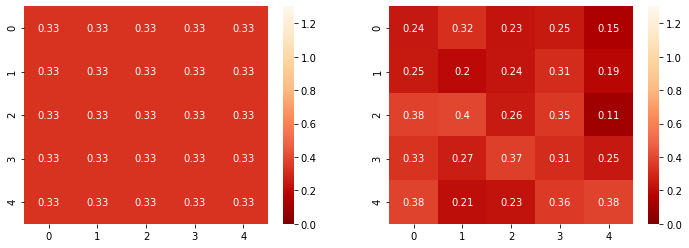

In [22]:
actual =  test['3'].to_numpy()
actual = np.reshape(actual,(actual.shape[0],1))
real=np.zeros((25,1))
predctd = np.zeros((25,1))

pos = int(input("Enter an integer between 0 to 6738 to test the model : "))
pos = pos*25+9

real=actual[pos:pos+25,-1]
predctd = predicted[pos:pos+25,-1]

real=np.reshape(real,(5,5))
predctd = np.reshape(predctd,(5,5))


print("Heatmap Actual and Heatmap predicted")
plt.figure(figsize=(12,4))
plt.subplot(121)
heat_map = sb.heatmap(real, vmin = 0, vmax = 1.30141, cmap="OrRd_r", annot=True)
plt.subplot(122)
heat_map = sb.heatmap(predctd,  vmin = 0, vmax = 1.30141, cmap="OrRd_r", annot=True)

In [ ]:
checkpoint = {'model': model,
             'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()}
torch.save(checkpoint, 'checkpoint_final.pth')